$\frac{\partial c}{\partial t} = D \nabla^2 (a (c-c_c)^3 - b (c-c_c) - \kappa \nabla ^2 (c-c_c) + B)$ Cahn-Hilliard equation coming from the Free energy functional $F[c] = \int d^3 r \left[ a/4 (c-c_c)^4 - a/8 (c-c_c)^2 + B (c-c_c) - \kappa \lvert \nabla (c-c_c\rvert ^2 \right]$. It is solved for $c^* = c-c_c$, $t = (w^2 / D) \tau$, $x = w x'$, $w = \sqrt{8\kappa/a}$

In [48]:
import os
import sys
import tempfile
import argparse
import subprocess
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time
import Functions
import Plotting
import imp 
from mpmath import *

In [29]:
Lx, Ly = 64., 64. # Physical length of the system
#Nx, Ny = 256, 256 # Discretization
Nx, Ny = 128, 128

Setup of the grid as 2 $N_i$x$N_i$ matrices $x,y$ with Length $L_i$ and spacing $dx, dy$.
Setup of the Fourier grid $k_{x,y}$ with $N_ixN_i$ matrices with spacing of $L_i/(2\pi N_i)$. 

In [30]:
x, y = np.meshgrid(np.arange(Nx) * Lx/Nx,np.arange(Ny) * Ly/Ny)
X = np.linspace(0, Lx, Nx-1)
Y = np.linspace(0, Ly, Ny-1)
dx, dy = Lx / Nx, Ly / Ny

kx, ky = np.meshgrid(np.fft.fftfreq(Nx,Lx/(Nx*2.0*np.pi)), np.fft.fftfreq(Ny,Ly/(Ny*2.0*np.pi)))
ksquare = kx*kx + ky*ky

Setup the initial condition for the simulation

In [31]:
c_1 = 32 * dx
c_2 = 4. * dx
cI = np.zeros((Nx,Ny))
e_1 = 4. * dx
ellipt = 0.1
e_2 = e_1 * np.sqrt(1-ellipt**2)
for i in range(Nx):
    for j in range(Ny):
        Ellipse = ((i-(Nx/2))/e_1)**2 + ((j-(Ny/2))/e_2)**2 # Ellipse <= 1
        #if (((i-64)**2 + (j-64)**2) < (c_2 * c_2)):
        if (Ellipse <= 1.):
            cI[i][j] = 1.
        else:
            cI[i][j] = 0.3
amp=0.1
#cI=((np.random.random((Nx,Ny))-0.5)*2)*amp
cI=0.2 + ((np.random.random((Nx,Ny))-0.5)*2)*amp


Definition of the parameters: Divergence term prefactor $\kappa$, Diffusive Mobility $D$, Reactive Mobility Rtot, Mobility of the broken balance Reaction $R2$, Chemical potential for the broken balance Reaction $\mu _2$, disturbance from a symmetric Free energy $B$, start time $t$, timestep $h$, final time $T$, Number of Timesteps $N_t$, critical concentration $c_c$, Fourth order coefficient $a$, second order coefficient $b$, Florence Huggins parameter $\chi$

Turnover:  0.01
Supersaturation: 0.3
0.0005 -0.0075 -0.01 -0.01
(0.0, 0.017000000000000008, -0.072, 0.048)


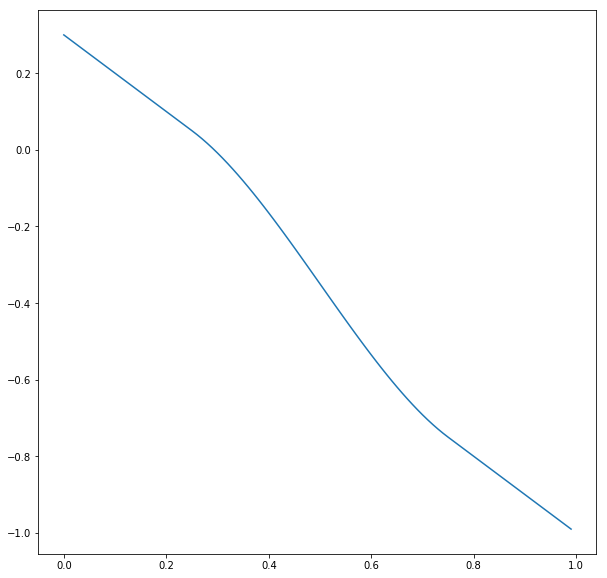

In [32]:
imp.reload(Functions)
''' --- Parameter Values needed for the Dimensional CH-Problem --- '''
kappa = 3.
D = 1.
Rtot = 0. # Rtot is the total Reaction Mobility = R1 + R2
R2 = 0.
a = 4.
b = 1.

''' --- Initial Time Parameters --- '''
h = 0.0025
T_End = 10000
t = 0.0
#N_t = int(T_End / h)
N_t = int(175 / h)

''' --- Parameters for the non dimensional CH-Problem --- '''
mu2 = 0.5 # in units of a
B = mu2 / 2. # Linear Parameter in the energy
B = 0.
c_c = 0.5
w = np.sqrt(8. * kappa / a) # Length scale of the system desribed by the divergence parameter and the Free energy scale
tc = w * w / (D * a) # time scale defined by the interface width and the Diffusion coefficient
lam1 = (Rtot / D) * w * w
lam2 = (R2 / D) * w * w
# lamda 1/2 is the non dimensionalized Form of the mobility 
# lambda 1/2 = (lambda Reaction 1/2)/(Diffusive Mobility) * Length scale ^2, Length scale = w = 1
# t = t_c * tau, t_c = (Length Scale ^2)/(Diffusive Mobility * Energy scale) defines the Time,
# h is given in units of t_c

''' --- Parameters for the non dimensional RD-Problem --- '''
#Length Scale: Interface width = 2 sqrt(kappa/a)
w = 2 * np.sqrt(kappa / a)
#Concentration scale c01 - c02 = 1
dc = 1.
#Diffusion Coefficient
D = 1.
#Time Scale
tc = w * w / D
# Dimensionless Reaction Rates k+/- = k+/- * tc
kin = 1e-2
kout = 1e-2
# Dimensionless Fluxes gamma+/- = gamma+/- * tc / dc
gammain = 1.e-2
gammaout = 3.e-3
# Dimensionless Concentrations c0 = c0 / dc
c0in = 1.
c0out = 0.
c_cin = 0.75
c_cout = 0.25
# Resulting Parameters: Turnover = gamma_in / dc, Supersaturation = (c_inf - c+0) / dc, c_inf = gammaout / (kout * dc)
turn = gammain
eps = gammaout / kout
print('Turnover: ', turn)
print('Supersaturation:', eps)

cspline = np.zeros((4))
cspline = Functions.Spline(gammain, gammaout, kin, kout, c0in, c0out, c_cin, c_cout)
ct = np.arange(0,1,(1/100.))
def f(x):
    condlist = [x < c_cout, (x >= c_cout) & (x <= c_cin),x > c_cin]
    funclist = [lambda x: gammaout - kout * (x - c0out), lambda x: cspline[0] + cspline[1] * x + cspline[2] * x**2 + cspline[3] * x**3, lambda x: -gammain - kin * (x - c0in)]
    return np.piecewise(x, condlist, funclist)
plt.plot(ct,(f(ct)/gammain))
print(cspline)

In [33]:
plotEveryNth = 2000
plt.rcParams["figure.figsize"] = [10,10]

Run the simulation until the final time is reached and plot the results

In [181]:
Plotting.remove('temp')
os.mkdir('temp') 

imp.reload(Functions)
imp.reload(Plotting)

Nt2 = int(N_t / plotEveryNth)
th = np.arange((Nt2))
IntFrac = np.zeros((Nt2))

#c = cI
times = np.zeros((N_t))
fd = 0
ps = 0
psND = 0
RDND = 1    

for i in range(N_t):
        
    if (RDND == 1):
        start = time.time()
        times[i] = start
        k,s = Functions.RDDL((c), kin, kout, c0in, c0out, gammain, gammaout, ksquare, cspline, c_cin, c_cout, c_c)
        c = c + h * k
        timeps = time.time() - start

    if (psND == 1):
        start = time.time()
        times[i] = start
        lambda1, lambda2 = Functions.Lambda(c, (0.901-0.001), 0.001, (0.001-0.051), 0.051)
        lambdatot = lambda1 + lambda2
        k = Functions.psDL((c-c_c), lambdatot, lambda2, ksquare, mu2, B, c_c)
        c = c + h * k
        timeps = time.time() - start
    
    if(i % plotEveryNth == 0):
        Cons = (c).sum()/(Nx*Ny)
        mu, mugrad = Functions.mu((c-c_c), ksquare, kappa, a, b, B, c_c)
        #Flux = - lambda1 * (mu + mugrad) - lambda2 * (mu + mugrad - mu2)
        Flux = s
        musum = (mu+mugrad).sum()/(Nx*Ny)
        Fluxtot = Flux.sum()
        jx, jy = Functions.flux(c, Nx, Ny, dx, dy)
        print(Cons, musum, Fluxtot, np.amin(c), np.amax(c))
        Plotting.plot(x,y,(c),0,1,'c',(i/plotEveryNth))
        Plotting.Lineplot(x[int(Nx/2)],c[:][int(Nx/2)],int(Nx/2),'Lineplot',(i/plotEveryNth))
        Plotting.plot(x,y,Flux,(np.amin(Flux)),(np.amax(Flux)),'Reaction Flux',(i/plotEveryNth))
        Plotting.plot(x,y,((mu+mugrad)),(np.amin((mu+mugrad))),(np.amax((mu+mugrad))),'mutot',(i/plotEveryNth))
        Plotting.plotvec(X, Y, jy, jx, 'DiffFlux', (i/plotEveryNth))
        if (i > 0):
            print(timeps, (times[i]-times[i-plotEveryNth]))
    

0.248170169159 0.0242280588111 -0.000621383458032 0.079572453667 0.96680315652
0.248169979878 0.024227869461 -0.000619087808528 0.0795729043645 0.96681224803
0.0032858848571777344 8.33735275269
0.248169791302 0.024227680945 -0.000616759371796 0.0795733517992 0.966821087365
0.003161907196044922 8.20092439651
0.248169603441 0.0242274932556 -0.000614401074838 0.0795737959982 0.966829675822
0.0031385421752929688 8.2027900219
0.248169416305 0.0242273063858 -0.00061201305841 0.079574236989 0.966839621739
0.0031778812408447266 8.29527258873
0.248169229898 0.024227120329 -0.000609621426154 0.0795746747987 0.966850750432
0.0031409263610839844 8.23414325714
0.248169044222 0.0242269350791 -0.000607231922131 0.0795751094547 0.966861752147
0.0031423568725585938 8.16114616394
0.248168859272 0.0242267506307 -0.000604855331054 0.0795755409843 0.966872627754
0.003175020217895508 8.21080541611
0.248168675048 0.0242265669792 -0.000602475192047 0.0795759694148 0.966883378116
0.003103971481323242 8.1672234

In [ ]:
imp.reload(Plotting)

Plotting.video('c(x,y,t)','Droplets_ReactConc-Lattice2', 1)
Plotting.video('j(x,y,t)','Droplets_ReactJ-Lattice2', 3)
Plotting.video('m(x,y,t)','Droplets_Reactmu-Lattice2', 2)
Plotting.video('Int(x,y,t)','Droplets_ReactFlux-Lattice2', 4)

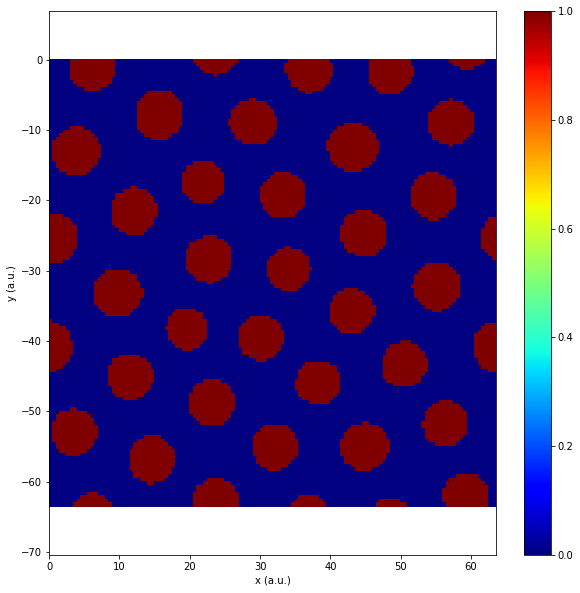

4621.0 4.58399386695
90.5096679919


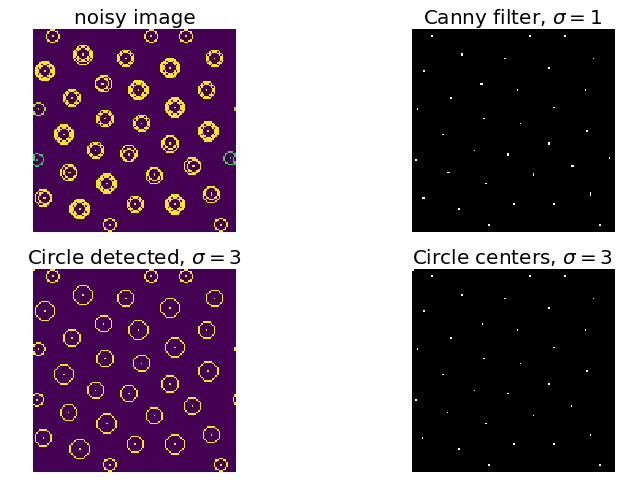

In [184]:
th = 0.25
s = Functions.Filter(c, th)

plt.cla()
plt.pcolormesh(x,-y,s,vmin=0,vmax=1, cmap = 'jet')
plt.colorbar()
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.axis('equal')
plt.axis([np.amin(x), np.amax(x), np.amin(-y), np.amax(-y)])
plt.show()
plt.close()

Plotting.plot(x,y,s,0,1,'s',(i/plotEveryNth))

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.feature import canny


# First trial with the Canny filter, with the default smoothing
# Increase the smoothing for better results
edges2 = canny(c, sigma=3)

edges = canny(c, sigma=1, low_threshold=0.1)

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharex=True, sharey=True)

hough_radii = np.arange(4, 17, 1)
hough_res = hough_circle(edges, hough_radii)
hough_res = hough_circle(s, hough_radii)
Np = 70

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=5, min_ydistance=5, total_num_peaks=Np, normalize=True) #,total_num_peaks=3
#print(accums)
image = np.zeros((Nx,Ny))
centers = np.zeros((Nx,Ny))

for center_y, center_x, radius, acc in zip(cy, cx, radii, accums):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    condlisty = [circy < 0, (circy>=0) & (circy<=Ny-1), circy > Ny-1]
    condlistx = [circx < 0, (circx>=0) & (circx<=Nx-1), circx > Nx-1]
    funclist = [lambda x: x+Ny, lambda x: x, lambda x: x-Ny]
    circy = np.piecewise(circy, condlisty, funclist)
    circx = np.piecewise(circx, condlistx, funclist)
    image[center_y,center_x] = acc#1.
    image[circy, circx]= acc#1.
    centers[center_y,center_x] = 1
    
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(centers, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

dist1 = np.zeros((Np,Np))
cx2, cy2, rad2 = np.zeros(Np), np.zeros(Np), np.zeros(Np)
thresh = 37
counter = 0.
Np2 = Np
Counter = np.zeros(Np)

print(s.sum(), ((np.sqrt(s.sum()/(Np2*np.pi)))))

maxr = np.sqrt(64**2 + 64**2)
print(maxr)

for i in range(Np):
    if (Counter[i] == 1):
        rad2[i] = 0
        cx2[i] = 0
        cy2[i] = 0
        dist1[i][:] = 0
        continue
    else:
        rad2[i] = radii[i]
        cx2[i] = cx[i]
        cy2[i] = cy[i]
        Counter[i] = 1
        for j in range(i,Np,1):
            if (i == j): 
                continue
            else:
                distx = np.absolute(cx[i] - cx[j])
                disty = np.absolute(cy[i] - cy[j])
                if (distx > Nx * 0.5): distx = Nx - distx
                if (disty > Ny * 0.5): disty = Ny - disty
                dist1[i][j] = distx ** 2 + disty ** 2
                dist1[j][i] = dist1[i][j]
                if (dist1[i][j] <= thresh):
                    counter += 1
                    Np2 -= 1
                    Counter[j] = 1
                    if (radii[i] <= radii[j]):
                        rad2[i] = radii[j]
                        radii[i] = radii[j]
                        cx[i] = cx[j]
                        cy[i] = cy[j]
                        cx2[i] = cx[j]
                        cy2[i] = cy[j]

cxfilt, cyfilt, radfilt = np.zeros(Np),np.zeros(Np), np.zeros(Np)

Np2 = 0
for i in range(Np):
    if (cx2[i] != 0):
        cxfilt[Np2], cyfilt[Np2], radfilt[Np2] = cx2[i], cy2[i], rad2[i]
        Np2 += 1
dist2 = np.zeros((Np2,Np2))

for i in range(Np2):
    for j in range(i,Np2,1):
            distx = np.absolute(cxfilt[i] - cxfilt[j])
            disty = np.absolute(cyfilt[i] - cyfilt[j])
            if (distx > Nx * 0.5): distx = Nx - distx
            if (disty > Ny * 0.5): disty = Ny - disty
            dist2[i][j] = np.sqrt(distx**2+disty**2)
            dist2[j][i] = dist2[i][j]
            if ((dist2[i][j] < np.sqrt(10)) & (i!=j)):
                print(dist2[i][j],i,j, cxfilt[i], cxfilt[j], cyfilt[i], cyfilt[j])
                
centers2 = np.zeros((Nx,Ny))
image2 = np.zeros((Nx,Ny))

for center_y, center_x, radius in zip(cyfilt, cxfilt, radfilt):
    circy2, circx2 = circle_perimeter(int(center_y), int(center_x), int(radius))
    condlisty = [circy2 < 0, (circy2>=0) & (circy2<=Ny-1), circy2 > Ny-1]
    condlistx = [circx2 < 0, (circx2>=0) & (circx2<=Nx-1), circx2 > Nx-1]
    funclist = [lambda x: x+Ny, lambda x: x, lambda x: x-Ny]
    circy2 = np.piecewise(circy2, condlisty, funclist)
    circx2 = np.piecewise(circx2, condlistx, funclist)
    centers2[int(center_y),int(center_x)] = 1
    image2[int(center_y),int(center_x)] = 1
    image2[circy2,circx2] = 1

ax3.imshow(image2)
ax3.axis('off')
ax3.set_title('Circle detected, $\sigma=3$', fontsize=20)  
    
ax4.imshow(centers2,cmap=plt.cm.gray)
ax4.axis('off')
ax4.set_title('Circle centers, $\sigma=3$', fontsize=20)    

fig.tight_layout()

centers_k = np.fft.ifft(centers)
filename = "example.png"
plt.savefig(filename)
plt.show()
plt.close()

528.0


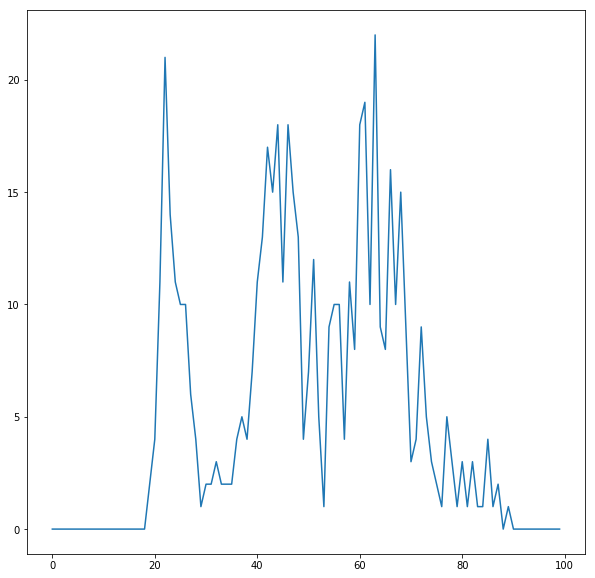

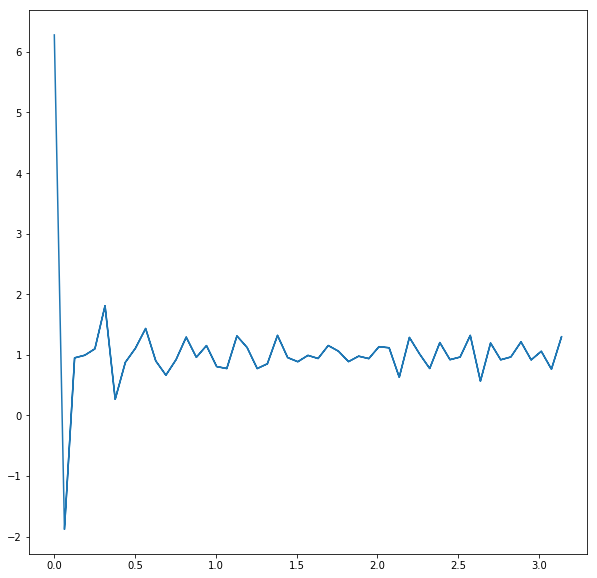

In [186]:
r0 = 0
r1 = 100.
dr = 1
Nr = int((r1-r0)/dr)
r = np.arange(r0,Nr,1)

rdf = np.zeros(Nr)

for rad in r:
    for i in range(Np2):
        for j in range(i,Np2,1):
            if (i!=j):
                if ((dist2[i][j] >= rad) & (dist2[i][j] < (rad+dr))):
                    rdf[rad] +=1
print(rdf.sum())
plt.plot(dr*r,rdf)
sfk = 1 + np.fft.ifft(rdf)
filename = "rdf.png"
plt.savefig(filename)
plt.show()
kr = np.fft.fftfreq(Nr,(r1-r0)/(Nr*2.0*np.pi))
Sk = np.zeros(Nr)
#for krad in r:
    #for i in range(Np2):
        #for k in range(Np2):
            #Sk[krad] += (1/Np2) * np.exp(-1j * kr[krad] * dist[i][k])
plt.plot(np.absolute(kr),sfk.real)
filename = "Struct.png"
plt.savefig(filename)
plt.show()
#plt.plot(np.absolute(kr),Sk.real)
#plt.show()